<a href="https://colab.research.google.com/github/OrionXV/Co-Lab-Misogny-Identifier/blob/main/AnotherMAMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimedia Automatic Misogyny Identification (MAMI)... <i> 3: The New Me </i>

A personal endeavour by Syed Arsalaan Nadim for the timebeing. 
In order to avoid clutter I am making a personal notebook.



In [1]:
!pip install torch
!pip install pytorch_lightning 
!pip install fasttext

     |████████████████████████████████| 526 kB 14.5 MB/s 
     |████████████████████████████████| 829 kB 68.3 MB/s 
     |████████████████████████████████| 133 kB 72.5 MB/s 
     |████████████████████████████████| 596 kB 73.1 MB/s 
     |████████████████████████████████| 332 kB 77.1 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 
     |████████████████████████████████| 192 kB 67.8 MB/s 
     |████████████████████████████████| 160 kB 70.9 MB/s 
     |████████████████████████████████| 271 kB 75.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a4d86abbca304b393835faa5d05d2566bc0582c3d12ac7df5a920269accc2bb7
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exi

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns  
sns.set()
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%config InLineBackend.figure_format = 'retina'
%matplotlib inline

import csv
import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
from tqdm import tqdm
import torch                    
import torchvision
import fasttext

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lqpl_ofWT1aJAG-aHFbgFdKpWx01QDv7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lqpl_ofWT1aJAG-aHFbgFdKpWx01QDv7" -O train.zip && rm -rf /tmp/cookies.txt

--2022-01-14 15:45:47--  https://docs.google.com/uc?export=download&confirm=cP4y&id=1lqpl_ofWT1aJAG-aHFbgFdKpWx01QDv7
Resolving docs.google.com (docs.google.com)... 142.251.31.139, 142.251.31.102, 142.251.31.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-9k-docs.googleusercontent.com/docs/securesc/bndrliup256v6d2ju8r86o4u2qr86iur/93ep86akands2iqvsl3io54oqt9ad7gr/1642175100000/04989237414475792611/06887636208553031366Z/1lqpl_ofWT1aJAG-aHFbgFdKpWx01QDv7?e=download [following]
--2022-01-14 15:45:47--  https://doc-08-9k-docs.googleusercontent.com/docs/securesc/bndrliup256v6d2ju8r86o4u2qr86iur/93ep86akands2iqvsl3io54oqt9ad7gr/1642175100000/04989237414475792611/06887636208553031366Z/1lqpl_ofWT1aJAG-aHFbgFdKpWx01QDv7?e=download
Resolving doc-08-9k-docs.googleusercontent.com (doc-08-9k-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting

In [4]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12KwkIoljStd8diaw5Aqz_RsKityaFudr' -O trial.zip 
#https://drive.google.com/file/d/1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd" -O test.zip && rm -rf /tmp/cookies.txt

--2022-01-14 15:46:01--  https://docs.google.com/uc?export=download&confirm=2Ixm&id=1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd
Resolving docs.google.com (docs.google.com)... 142.251.31.113, 142.251.31.138, 142.251.31.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6o-docs.googleusercontent.com/docs/securesc/gog3phpu5khruajd749bhf5dnsv09g7r/99fp7m6uv2bfabkdftdmn9a8t46qbksl/1642175100000/04989237414475792611/02249171083388885585Z/1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd?e=download [following]
--2022-01-14 15:46:01--  https://doc-00-6o-docs.googleusercontent.com/docs/securesc/gog3phpu5khruajd749bhf5dnsv09g7r/99fp7m6uv2bfabkdftdmn9a8t46qbksl/1642175100000/04989237414475792611/02249171083388885585Z/1mgZoWUz9jyEvLUD8S8qQMzEpDGM08jGd?e=download
Resolving doc-00-6o-docs.googleusercontent.com (doc-00-6o-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting

In [5]:
!unzip -q train.zip

In [6]:
#!unzip -q -P *MaMiSemEval2022! trial.zip
!unzip -q -P *MaMiSemEval2022! test.zip

In [7]:
import os
import glob

path = '/content/TRAINING'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)
path = '/content/test'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)

['training.csv']
['Test.csv']


In [8]:
data_path = Path.cwd().parent

training_path = data_path / "TRAINING"
train_csv_path = training_path / "training.csv"
test_path = data_path / "test"
test_csv_path = test_path / "Test.csv"

In [9]:
model_output_path = data_path / "model-outputs"
os.mkdir(model_output_path)

In [10]:
 data = pd.read_csv(train_csv_path, usecols=['file_name', 'misogynous', 'Text Transcription'], sep='\t')

In [11]:
data.head(), data['misogynous'].value_counts(), data['Text Transcription'].map(lambda text: len(text.split(" "))).describe()

(   file_name  misogynous                                 Text Transcription
 0      1.jpg           0                                      Milk Milk.zip
 1     10.jpg           1  ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S...
 2   1000.jpg           0  BREAKING NEWS: Russia releases photo of DONALD...
 3  10000.jpg           0                       MAN SEEKING WOMAN Ignad 18 O
 4  10006.jpg           0  Me explaining the deep lore of. J.R.R. Tolkein...,
 1    5000
 0    5000
 Name: misogynous, dtype: int64,
 count    10000.000000
 mean        18.058000
 std         15.053514
 min          1.000000
 25%         10.000000
 50%         15.000000
 75%         21.000000
 max        269.000000
 Name: Text Transcription, dtype: float64)

In [12]:
from PIL import Image


images = [
    Image.open(
        training_path / data.loc[i, "file_name"]
    ).convert("RGB")
    for i in range(16)
]

for image in images:
    print(image.size)

(640, 585)
(640, 640)
(526, 640)
(426, 640)
(640, 489)
(597, 640)
(414, 640)
(640, 365)
(354, 640)
(640, 633)
(434, 640)
(636, 640)
(640, 545)
(527, 640)
(606, 640)
(640, 423)


In [13]:
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(200, 200)),
        torchvision.transforms.ToTensor()
    ]
)

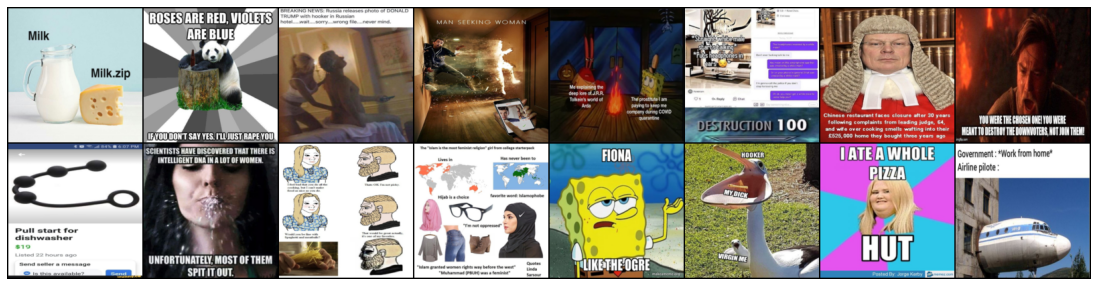

In [14]:
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))

In [15]:
df = pd.read_csv(test_csv_path,  sep='\t')
df.head()

,file_name,Text Transcription
0,15236.jpg,FACEBOOK SINGLES GROUPS BELIKE WHEN A NEW WOMA...
1,15805.jpg,"SO, IF YOU'RE A FEMINIST HOW CAN YOU EAT DAIRY?"
2,16254.jpg,WHEN A CUTE GIRL LEFT YOUR MESSAGE ON SEEN
3,16191.jpg,Photographing something you want to show every...
4,15952.jpg,HEY BABE CAN YOU MAKE ME A SANDWICH? Hey babe ...


In [16]:
df.head()

,file_name,Text Transcription
0,15236.jpg,FACEBOOK SINGLES GROUPS BELIKE WHEN A NEW WOMA...
1,15805.jpg,"SO, IF YOU'RE A FEMINIST HOW CAN YOU EAT DAIRY?"
2,16254.jpg,WHEN A CUTE GIRL LEFT YOUR MESSAGE ON SEEN
3,16191.jpg,Photographing something you want to show every...
4,15952.jpg,HEY BABE CAN YOU MAKE ME A SANDWICH? Hey babe ...


In [17]:
#df.to_csv(test_csv_path, index = True, sep = '\t')

# Model Creation 

Data Set Creation 

In [18]:
class MemeDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform
        
    ):
    
        self.samples_frame = pd.read_csv(data_path, sep='\t')

        self.samples_frame['file_path'] = self.samples_frame['file_name'].apply(
            lambda row: (Path(str(img_dir) + "/" +str(row)))
            ) 

        #self.samples_frame.set_index('file_name')

        self.img_dir = img_dir
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, 'file_name']
        '''
        torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, 'file_name'].replace("\n", "") #.apply(lambda id: id.strip()).to_string().
            )
        ).squeeze()
        '''
        image = Image.open(
            self.samples_frame.loc[idx, "file_path"]#.to_string()
        ).convert("RGB")

        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "Text Transcription"].replace("\n", "") #.apply(lambda id: id.strip()).to_string().
            )
        ).squeeze()

        if "misogynous" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "misogynous"]]
            ).long().squeeze()
            sample = {
                "file_name": img_id, 
                "image": image, 
                "Text Transcription": text, 
                "misogynous": label
            }
        else:
            sample = {
                "file_name": img_id, 
                "image": image, 
                "Text Transcription": text
            }

        return sample

In [19]:
class LangAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,     
    ):
        super().__init__()

        self.language_module = language_module
        self.vision_module = vision_module

        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )

        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )

        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)

    def forward(self, text, image, label = None):
        text_features = torch.nn.functional.relu(self.language_module(text))
        image_features = torch.nn.functional.relu(self.vision_module(image))
        combined = torch.cat([text_features, image_features], dim=1)
        fused = self.dropout(torch.nn.functional.relu(self.fusion(combined)))
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (self.loss_fn(pred, label) if label is not None else label)
        return (pred, loss)

In [20]:
!pip install torchmetrics

In [21]:
import pytorch_lightning as pl
from torchmetrics import functional as FM 

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)

In [22]:
class MemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in [
                         "train_path", 
                         "test_path", 
                         "train_img_dir",
                         "test_img_dir"
                    ]:
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super().__init__()
        self._hparams = hparams 

        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get("language_feature_dim", 300)

        # balance language and vision features by default
        self.vision_feature_dim = self.hparams.get("vision_feature_dim", self.language_feature_dim)
        self.output_path = self.hparams.get("output_path", Path("model-outputs"))
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset(data_key="train_path", img_dir="train_img_dir")
        self.test_dataset = self._build_dataset(data_key="test_path", img_dir="test_img_dir")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    @property
    def hparams(self):
        return self._hparams

    # Required LightningModule Methods (when validating) 
    
    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["Text Transcription"], 
            image=batch["image"], 
            label=batch["misogynous"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["Text Transcription"], 
            image=batch["image"], 
            label=batch["misogynous"]
        )

        acc = FM.accuracy(preds, batch["misogynous"], num_classes=2)
        self.log("batch_val_acc", acc)
        
        return {"batch_val_loss": loss, "batch_val_acc": acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        avg_acc = torch.stack(
            tuple(
                output["batch_val_acc"] 
                for output in outputs
            )
        ).mean()

        return {
            "val_acc": avg_acc,
            "progress_bar":{
                "avg_val_loss": avg_loss, 
                "avg_val_acc": avg_acc
                }
        }

    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.0001)
            )
        ]
        schedulers = [{'scheduler': x, 'monitor': 'batch_val_acc'} for x in [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0]
            )
        ]]
        tu = tuple(
            [
             {'optimizer' : op, 'lr_scheduler' : sch} for op, sch in zip(optimizers, schedulers)
            ]
        )
        return tu
    
    #@pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    #@pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            #self.test_dataset,
            self.train_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16),
        )

    def fit(self):
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
    
    # will improve further on this by making a few more methods... or well specifying them 
    
    def _build_text_transform(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:

                training_data = [ 
                                 str(line) + "/n" 
                                 for line in pd.read_csv(
                                     self.hparams.get('train_path'), usecols = ["Text Transcription"], sep = '\t'
                                    )
                                 ['Text Transcription']
                            ]

                for line in training_data:
                    ft.write(line + "\n")
                language_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.embedding_dim
                )
        return language_transform
    
    def _build_image_transform(self):
        image_dim = self.hparams.get("image_dim", 200)
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return image_transform

    def _build_dataset(self, data_key, img_dir):
        return MemeDataset(
            data_path = self.hparams.get(data_key),
            img_dir = self.hparams.get(img_dir), 
            image_transform = self.image_transform,
            text_transform = self.text_transform,
            # limit training samples only
        )

    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        language_module = torch.nn.Linear(
                in_features=self.embedding_dim,
                out_features=self.language_feature_dim
        )
        
        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.resnet152(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LangAndVisionConcat(
            num_classes = self.hparams.get("num_classes", 2),
            loss_fn = torch.nn.CrossEntropyLoss(),
            language_module = language_module,
            vision_module = vision_module,
            language_feature_dim = self.language_feature_dim,
            vision_feature_dim = self.vision_feature_dim,
            fusion_output_size = self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p = self.hparams.get("dropout_p", 0.1),
        )

    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath = self.output_path,
            monitor = self.hparams.get(
                "checkpoint_monitor", "batch_val_acc"
            ),
            mode = self.hparams.get(
                "checkpoint_monitor_mode", "max"
            ),
            verbose = self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor = self.hparams.get(
                "early_stop_monitor", "batch_val_acc"
            ),
            min_delta = self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience = self.hparams.get(
                "early_stop_patience", 5
            ),
            verbose = self.hparams.get("verbose", True),
        )

        trainer_params = {
            "callbacks" : [early_stop_callback],
            "checkpoint_callback": checkpoint_callback,
            #"early_stop_callback": early_stop_callback,
            #"default_save_path": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
    
    @torch.no_grad()
    def make_submission_frame(self, test_path , img_dir):
        test_dataset = self._build_dataset(test_path, img_dir)
        submission_frame = pd.DataFrame(
            index = test_dataset.samples_frame.file_name,
            columns=["proba", "misogynous"]
        )

        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle = False, 
            batch_size = self.hparams.get("batch_size", 4), 
            num_workers = self.hparams.get("num_workers", 16)
        )
        
        for batch in tqdm(test_dataloader, total = len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["Text Transcription"], batch["image"]
            )
            submission_frame.loc[batch["file_name"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["file_name"], "misogynous"] = preds.argmax(dim=1)
            
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.misogynous.astype(int)
        return submission_frame    
    

In [23]:
hparams = {
    "train_path": train_csv_path,
    "test_path": test_csv_path,
    "train_img_dir": training_path,
    "test_img_dir": test_path,

    

    "embedding_dim": 150,
    "language_feature_dim": 200,
    "vision_feature_dim": 200,
    "fusion_output_size": 256,
    "output_path": model_output_path,
    "lr": 0.00005,
    "max_epochs": 10,
    "n_gpu": 1,
    "batch_size": 16,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 5,
}


miso_memes_model = MemesModel(hparams = hparams)
miso_memes_model.fit()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/test/lightning_logs

  | Name  | Type                | Params
----------------------------------------------
0 | model | LangAndVisionConcat | 58.7 M
----------------------------------------------
58.7 M    Trainable params
0         Non-trainable params
58.7 M    Total params
234.748   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric batch_val_acc improved. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric batch_val_acc did not improve in the last 5 records. Best score: 0.782. Signaling Trainer to stop.


In [24]:
%load_ext tensorboard
%tensorboard --logdir = /content/test/lightning_logs/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

In [25]:
#https://drive.google.com/file/d/1Sr-A4TUJK4xxojUWXa032a8WNVMk-uXr/view?usp=sharing
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Sr-A4TUJK4xxojUWXa032a8WNVMk-uXr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Sr-A4TUJK4xxojUWXa032a8WNVMk-uXr" -O epoch=5-step=239.ckpt && rm -rf /tmp/cookies.txt

In [26]:
#model_output_path = data_path / "model-outputs"
checkpt = Path("/content/test/lightning_logs/version_0/checkpoints")
checkpoints = list(checkpt.glob("*.ckpt"))
assert len(checkpoints) == 1

checkpoints

[PosixPath('/content/test/lightning_logs/version_0/checkpoints/epoch=5-step=239.ckpt')]

In [27]:
'''
hparams_file = Path("/content/TRAINING/lightning_logs/version_0/hparams.yaml")
hparams_file
'''

'\nhparams_file = Path("/content/TRAINING/lightning_logs/version_0/hparams.yaml")\nhparams_file\n'

In [28]:
test_csv_path = "test_path" #"/content/test/Test.csv"
test_img_dir = "test_img_dir" #"/content/test"

In [29]:
miso_memes_model_best = MemesModel.load_from_checkpoint(checkpoints[0], hparams= hparams)

In [30]:
submission = miso_memes_model_best.make_submission_frame(test_path = test_csv_path, img_dir = test_img_dir)
submission.head() 

100%|██████████| 63/63 [04:22<00:00,  4.17s/it]


,proba,misogynous
file_name,,
15236.jpg,0.213706,0
15805.jpg,0.999441,1
16254.jpg,0.998681,1
16191.jpg,0.041200,0
15952.jpg,0.999993,1


In [31]:
submission.to_csv("submission.csv", index=True)

In [33]:
submission.shape

(1000, 2)

In [34]:
submission.loc[:, "misogynous"].mean()

0.746

In [35]:
path = '/content/TRAINING'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)
path = '/content/test'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)

['training.csv']
['submission.csv', 'Test.csv']


In [36]:
from google.colab import files
files.download('submission.csv') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>